# Iron Ore Trading Simulation - P&L Analysis

This notebook:
1. Fetches indicator signals from the backtest
2. Fetches actual price data (OHLCV)
3. Simulates trading with $1000 starting capital
4. Calculates and visualizes P&L curve

**Signal Logic:**
- Signal = 1: BUY (enter long position)
- Signal = -1: SELL (enter short position or close long)
- Signal = 0: NEUTRAL (hold current position)

In [15]:
# Import required libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import asyncio
import svr3
import pycaitlynutils3 as pcu3

# Enable Jupyter async support
try:
    import nest_asyncio
    nest_asyncio.apply()
    print("✓ nest_asyncio applied (Jupyter compatibility)")
except ImportError:
    print("⚠️  Install with: pip install nest-asyncio")

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (15, 8)

✓ nest_asyncio applied (Jupyter compatibility)


## Configuration

Load connection parameters from environment variables.

In [ ]:
# Server configuration - Load from environment
SVR_HOST = os.getenv("SVR_HOST", "10.99.100.116")
TOKEN = os.getenv("SVR_TOKEN")

if not TOKEN:
    raise ValueError("SVR_TOKEN environment variable not set! Set it with: export SVR_TOKEN='your_token'")

RAILS_URL = f"https://{SVR_HOST}:4433/private-api/"
WS_URL = f"wss://{SVR_HOST}:4433/tm"
TM_MASTER = (SVR_HOST, 6102)

# Data configuration
MARKET = "DCE"
CODE = "i<00>"  # Iron Ore logical contract
GRANULARITY = 900  # 15 minutes

# Time range (matching your quick test: 2024-10-25 to 2024-11-01)
START_DATE = "20241001"
END_DATE = "20241231"

# Trading simulation parameters
INITIAL_CAPITAL = 1000.0  # $1000 starting capital

print(f"✓ Configuration loaded")
print(f"  Market: {MARKET}")
print(f"  Instrument: {CODE}")
print(f"  Date Range: {START_DATE} to {END_DATE}")
print(f"  Initial Capital: ${INITIAL_CAPITAL:.2f}")

✓ Configuration loaded
  Market: DCE
  Instrument: i<00>
  Date Range: 20241001000000 to 20241231235959
  Initial Capital: $1000.00


## Data Fetching Functions

Fetch both indicator signals and price data using svr3 API.

In [17]:
async def fetch_data_from_server(
    market: str,
    code: str,
    start_date: str,
    end_date: str,
    algoname: str,
    namespace: str
) -> pd.DataFrame:
    """
    Fetch data from svr3 server with proper connection sequence.
    
    Args:
        market: Market name (e.g., "DCE")
        code: Instrument code (e.g., "i<00>")
        start_date: Start date as YYYYMMDD string
        end_date: End date as YYYYMMDD string
        algoname: Algorithm/data source name
        namespace: "global" for raw data, "private" for indicators
    
    Returns:
        DataFrame with fetched data
    """
    try:
        # Convert dates to integer timestamps
        start_time = int(start_date + "000000")
        end_time = int(end_date + "235959")
        
        print(f"   📥 Fetching {algoname} data for {market}/{code}...")
        
        # Create sv_reader instance (arguments are positional!)
        reader = svr3.sv_reader(
            start_time,
            end_time,
            algoname,
            GRANULARITY,
            namespace,
            "symbol",
            [market],
            [code],
            False,
            RAILS_URL,
            WS_URL,
            "",
            "",
            TM_MASTER,
        )
        
        # Set token after initialization
        reader.token = TOKEN
        
        # Connection sequence (EXACT ORDER REQUIRED)
        await reader.login()
        await reader.connect()
        reader.ws_task = asyncio.create_task(reader.ws_loop())
        await reader.shakehand()
        
        # Fetch data
        ret = await reader.save_by_symbol()
        data = ret[1][1]
        
        if not data or len(data) == 0:
            print(f"   ⚠️  No data returned")
            return pd.DataFrame()
        
        # Convert to DataFrame
        df = pd.DataFrame(data)
        
        # Parse timestamps
        if 'time_tag' in df.columns:
            df['timestamp'] = pd.to_datetime(df['time_tag'].apply(pcu3.ts_parse))
        
        print(f"   ✓ Fetched {len(df)} bars")
        return df
        
    except Exception as e:
        import traceback
        print(f"   ❌ Error fetching data: {e}")
        print(traceback.format_exc())
        return pd.DataFrame()

print("✓ Data fetching functions defined")

✓ Data fetching functions defined


## Fetch Indicator Signals

Load the indicator signals from the private namespace.

In [18]:
# Fetch indicator data (signals, RSI values, etc.)
print("\n=== Fetching Indicator Signals ===")
indicator_df = await fetch_data_from_server(
    market=MARKET,
    code=CODE,
    start_date=START_DATE,
    end_date=END_DATE,
    algoname="IronOreIndicator",
    namespace="private"
)

if len(indicator_df) > 0:
    print(f"\n✓ Loaded {len(indicator_df)} indicator bars")
    print(f"\nColumns: {list(indicator_df.columns)}")
    print(f"\nFirst few rows:")
    display(indicator_df.head())
else:
    print("\n❌ No indicator data found!")


=== Fetching Indicator Signals ===
   📥 Fetching IronOreIndicator data for DCE/i<00>...
   ❌ Error fetching data: year 2024100100 is out of range
Traceback (most recent call last):
  File "/tmp/ipykernel_24583/4289300935.py", line 31, in fetch_data_from_server
    reader = svr3.sv_reader(
  File "/home/wolverine/bin/running/svr3.py", line 29, in __init__
    self.init(
  File "/home/wolverine/bin/running/svr3.py", line 62, in init
    self.from_ = self._int_to_timetag(start) if start is not None else 0
  File "/home/wolverine/bin/running/svr3.py", line 38, in _int_to_timetag
    return self.time_tag(tm//10000000000, tm//100000000 % 100,
  File "/home/wolverine/bin/running/backtest_runner3.py", line 925, in time_tag
    tm = datetime.datetime(y, m, d, H, M, S, tzinfo=datetime.timezone.utc)
ValueError: year 2024100100 is out of range


❌ No indicator data found!


## Fetch Price Data (OHLCV)

Load actual market prices to simulate trading.

In [5]:
# Fetch price data (OHLCV)
print("\n=== Fetching Price Data ===")
price_df = await fetch_data_from_server(
    market=MARKET,
    code=CODE,
    start_date=START_DATE,
    end_date=END_DATE,
    algoname="SampleQuote",
    namespace="global"
)

if len(price_df) > 0:
    print(f"\n✓ Loaded {len(price_df)} price bars")
    print(f"\nFirst few rows:")
    display(price_df.head())
else:
    print("\n❌ No price data found!")


=== Fetching Price Data ===
   📥 Fetching SampleQuote data for DCE/i<00>...
   ✓ Fetched 138 bars

✓ Loaded 138 price bars

First few rows:


,time_tag,granularity,code,market,struct_market,struct_code,namespace,open,close,high,low,volume,turnover,timestamp
0,1729818900000,900,i<00>,DCE,DCE,i<00>,0,765.0,762.5,765.5,762.0,18949,1.446803e+09,2024-10-25 01:15:00+00:00
1,1729819800000,900,i<00>,DCE,DCE,i<00>,0,763.0,764.0,764.5,761.0,10913,8.321596e+08,2024-10-25 01:30:00+00:00
2,1729820700000,900,i<00>,DCE,DCE,i<00>,0,764.0,766.5,767.5,763.0,16401,1.255601e+09,2024-10-25 01:45:00+00:00
3,1729821600000,900,i<00>,DCE,DCE,i<00>,0,767.0,763.0,767.0,762.5,10772,8.229895e+08,2024-10-25 02:00:00+00:00
4,1729822500000,900,i<00>,DCE,DCE,i<00>,0,763.0,767.0,767.0,761.5,14027,1.070985e+09,2024-10-25 02:15:00+00:00


## Merge Data and Prepare for Simulation

Combine indicator signals with price data.

In [6]:
# Merge indicator signals with price data on timestamp
df = pd.merge(
    indicator_df[['timestamp', 'signal', 'indicator_value', 'bar_index']],
    price_df[['timestamp', 'open', 'high', 'low', 'close', 'volume']],
    on='timestamp',
    how='inner'
)

# Sort by timestamp
df = df.sort_values('timestamp').reset_index(drop=True)

print(f"\n✓ Merged data: {len(df)} bars")
print(f"\nSignal distribution:")
print(df['signal'].value_counts().sort_index())
print(f"\nMerged data preview:")
display(df.head(10))


✓ Merged data: 114 bars

Signal distribution:
signal
-1      1
 0    113
Name: count, dtype: int64

Merged data preview:


,timestamp,signal,indicator_value,bar_index,open,high,low,close,volume
0,2024-10-25 01:15:00+00:00,0,47.981440,8,765.0,765.5,762.0,762.5,18949
1,2024-10-25 01:30:00+00:00,0,64.924560,9,763.0,764.5,761.0,764.0,10913
2,2024-10-25 01:45:00+00:00,0,42.541353,10,764.0,767.5,763.0,766.5,16401
3,2024-10-25 02:00:00+00:00,0,60.499336,11,767.0,767.0,762.5,763.0,10772
4,2024-10-25 02:15:00+00:00,0,62.203125,12,763.0,767.0,761.5,767.0,14027
5,2024-10-25 02:45:00+00:00,0,68.478339,13,766.5,768.0,765.0,767.5,13019
6,2024-10-25 03:00:00+00:00,0,59.875688,14,767.5,771.0,766.5,769.5,27039
7,2024-10-25 03:15:00+00:00,0,70.016734,15,769.0,770.0,767.0,768.0,15252
8,2024-10-25 03:30:00+00:00,0,70.016734,16,768.0,772.0,766.0,771.5,16550
9,2024-10-25 05:45:00+00:00,0,70.016734,17,770.5,774.0,769.5,771.5,24822


## Trading Simulation

Simulate trading based on signals with $1000 starting capital.

**Trading Rules:**
- Start with $1000 cash, 0 position
- Signal = 1 (BUY): If not in position, buy at next bar's close
- Signal = -1 (SELL): If in position, sell at next bar's close
- Signal = 0 (NEUTRAL): Hold current position
- Calculate P&L based on position changes

In [7]:
def simulate_trading(df, initial_capital=1000.0):
    """
    Simulate trading based on signals.
    
    Args:
        df: DataFrame with 'signal', 'close' columns
        initial_capital: Starting cash amount
    
    Returns:
        DataFrame with trading simulation results
    """
    df = df.copy()
    
    # Initialize portfolio state
    cash = initial_capital
    position = 0  # Number of contracts held
    entry_price = 0.0
    
    # Track portfolio value over time
    portfolio_values = []
    positions = []
    cash_values = []
    trades = []
    
    for i in range(len(df)):
        signal = df.loc[i, 'signal']
        close_price = df.loc[i, 'close']
        
        # Execute trades based on signals
        if signal == 1 and position == 0:  # BUY signal, not in position
            # Calculate how many contracts we can buy
            # Simplified: buy 1 contract per $100 (adjust based on actual contract size)
            contracts_to_buy = max(1, int(cash / close_price))
            cost = contracts_to_buy * close_price
            
            if cost <= cash:
                position = contracts_to_buy
                cash -= cost
                entry_price = close_price
                trades.append({
                    'timestamp': df.loc[i, 'timestamp'],
                    'action': 'BUY',
                    'contracts': contracts_to_buy,
                    'price': close_price,
                    'value': cost
                })
        
        elif signal == -1 and position > 0:  # SELL signal, in position
            # Close position
            proceeds = position * close_price
            cash += proceeds
            trades.append({
                'timestamp': df.loc[i, 'timestamp'],
                'action': 'SELL',
                'contracts': position,
                'price': close_price,
                'value': proceeds,
                'pnl': (close_price - entry_price) * position
            })
            position = 0
            entry_price = 0.0
        
        # Calculate current portfolio value
        position_value = position * close_price
        portfolio_value = cash + position_value
        
        portfolio_values.append(portfolio_value)
        positions.append(position)
        cash_values.append(cash)
    
    # Add results to dataframe
    df['portfolio_value'] = portfolio_values
    df['position'] = positions
    df['cash'] = cash_values
    df['pnl'] = df['portfolio_value'] - initial_capital
    df['returns'] = df['portfolio_value'].pct_change().fillna(0)
    
    return df, trades

# Run simulation
print("\n=== Running Trading Simulation ===")
df_sim, trades = simulate_trading(df, INITIAL_CAPITAL)

print(f"\n✓ Simulation complete")
print(f"  Total trades: {len(trades)}")
print(f"  Final portfolio value: ${df_sim['portfolio_value'].iloc[-1]:.2f}")
print(f"  Total P&L: ${df_sim['pnl'].iloc[-1]:.2f}")
print(f"  Return: {(df_sim['pnl'].iloc[-1] / INITIAL_CAPITAL * 100):.2f}%")

if len(trades) > 0:
    print("\nTrade history:")
    trades_df = pd.DataFrame(trades)
    display(trades_df)


=== Running Trading Simulation ===

✓ Simulation complete
  Total trades: 0
  Final portfolio value: $1000.00
  Total P&L: $0.00
  Return: 0.00%


## P&L Curve Visualization

Visualize portfolio performance over time.


✓ Saved: pnl_analysis.png


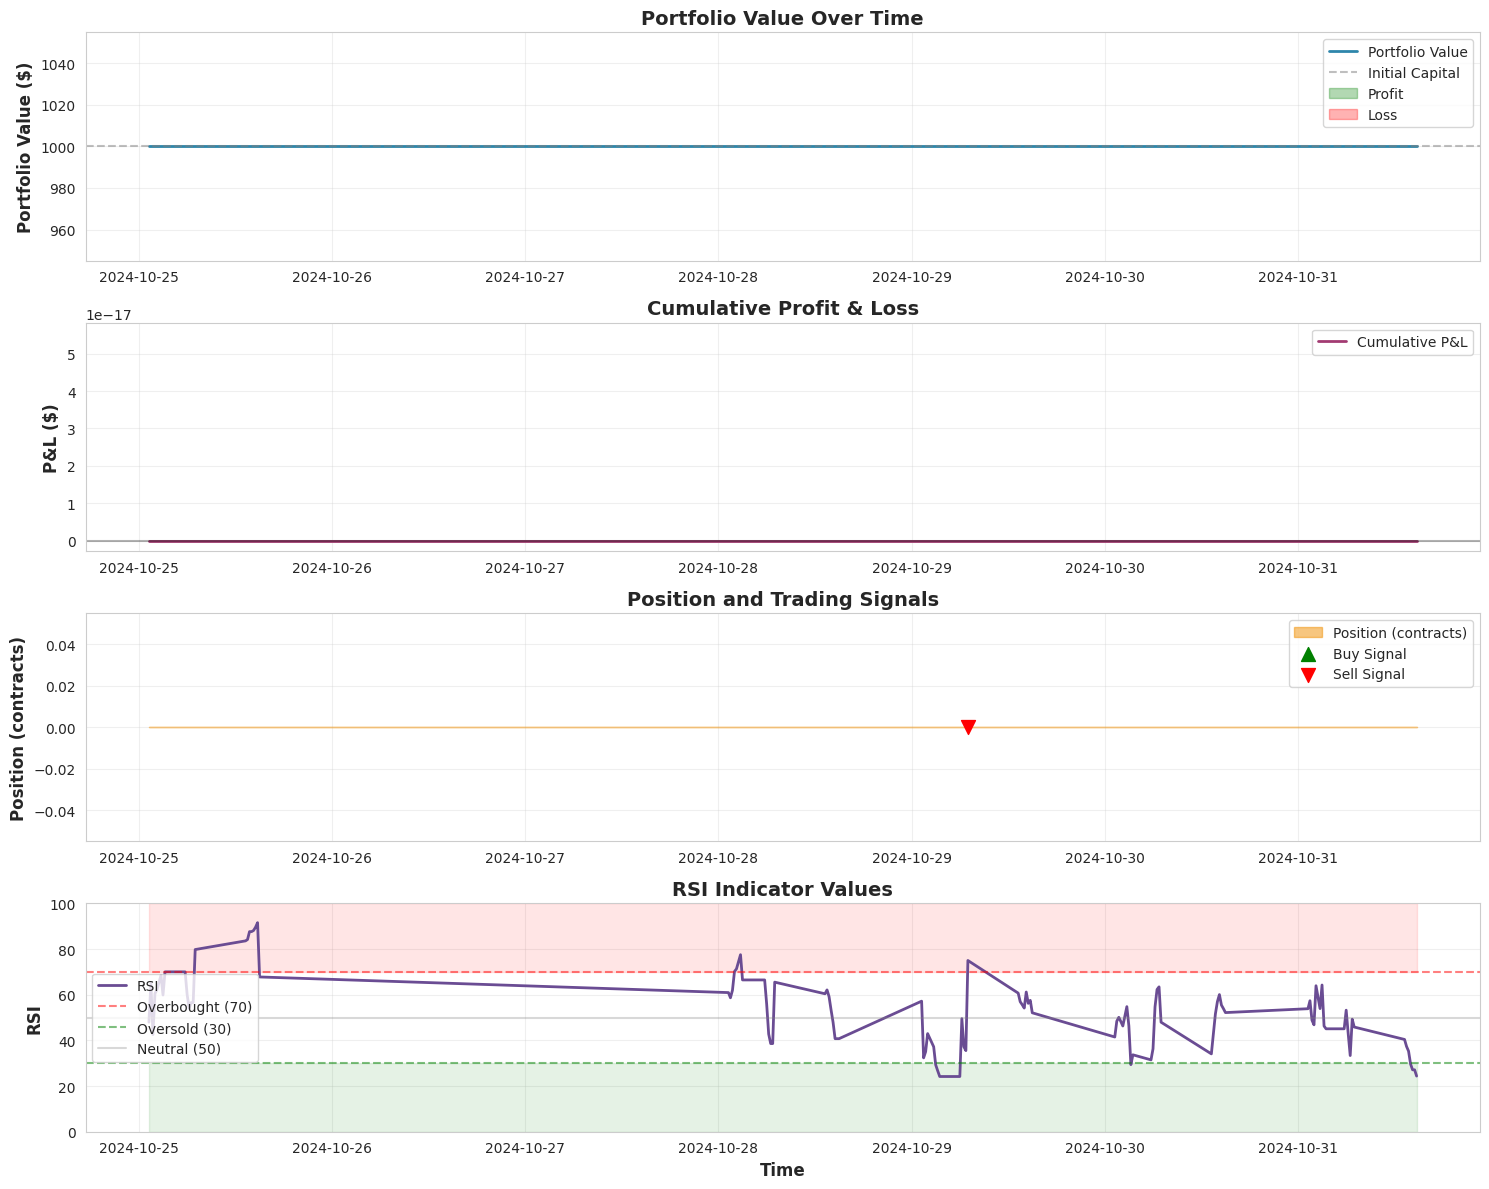

In [8]:
# Create comprehensive P&L visualization
fig, axes = plt.subplots(4, 1, figsize=(15, 12))

# Plot 1: Portfolio Value Over Time
ax1 = axes[0]
ax1.plot(df_sim['timestamp'], df_sim['portfolio_value'], linewidth=2, color='#2E86AB', label='Portfolio Value')
ax1.axhline(y=INITIAL_CAPITAL, color='gray', linestyle='--', alpha=0.5, label='Initial Capital')
ax1.fill_between(df_sim['timestamp'], INITIAL_CAPITAL, df_sim['portfolio_value'], 
                  where=(df_sim['portfolio_value'] >= INITIAL_CAPITAL), 
                  alpha=0.3, color='green', label='Profit')
ax1.fill_between(df_sim['timestamp'], INITIAL_CAPITAL, df_sim['portfolio_value'], 
                  where=(df_sim['portfolio_value'] < INITIAL_CAPITAL), 
                  alpha=0.3, color='red', label='Loss')
ax1.set_ylabel('Portfolio Value ($)', fontsize=12, fontweight='bold')
ax1.set_title('Portfolio Value Over Time', fontsize=14, fontweight='bold')
ax1.legend(loc='best')
ax1.grid(True, alpha=0.3)

# Plot 2: Cumulative P&L
ax2 = axes[1]
ax2.plot(df_sim['timestamp'], df_sim['pnl'], linewidth=2, color='#A23B72', label='Cumulative P&L')
ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)
ax2.fill_between(df_sim['timestamp'], 0, df_sim['pnl'], 
                  where=(df_sim['pnl'] >= 0), alpha=0.3, color='green')
ax2.fill_between(df_sim['timestamp'], 0, df_sim['pnl'], 
                  where=(df_sim['pnl'] < 0), alpha=0.3, color='red')
ax2.set_ylabel('P&L ($)', fontsize=12, fontweight='bold')
ax2.set_title('Cumulative Profit & Loss', fontsize=14, fontweight='bold')
ax2.legend(loc='best')
ax2.grid(True, alpha=0.3)

# Plot 3: Position and Signals
ax3 = axes[2]
ax3.fill_between(df_sim['timestamp'], 0, df_sim['position'], alpha=0.5, color='#F18F01', label='Position (contracts)')
# Mark buy/sell signals
buy_signals = df_sim[df_sim['signal'] == 1]
sell_signals = df_sim[df_sim['signal'] == -1]
ax3.scatter(buy_signals['timestamp'], buy_signals['position'], color='green', marker='^', s=100, label='Buy Signal', zorder=5)
ax3.scatter(sell_signals['timestamp'], sell_signals['position'], color='red', marker='v', s=100, label='Sell Signal', zorder=5)
ax3.set_ylabel('Position (contracts)', fontsize=12, fontweight='bold')
ax3.set_title('Position and Trading Signals', fontsize=14, fontweight='bold')
ax3.legend(loc='best')
ax3.grid(True, alpha=0.3)

# Plot 4: RSI Indicator
ax4 = axes[3]
ax4.plot(df_sim['timestamp'], df_sim['indicator_value'], linewidth=2, color='#6A4C93', label='RSI')
ax4.axhline(y=70, color='red', linestyle='--', alpha=0.5, label='Overbought (70)')
ax4.axhline(y=30, color='green', linestyle='--', alpha=0.5, label='Oversold (30)')
ax4.axhline(y=50, color='gray', linestyle='-', alpha=0.3, label='Neutral (50)')
ax4.fill_between(df_sim['timestamp'], 70, 100, alpha=0.1, color='red')
ax4.fill_between(df_sim['timestamp'], 0, 30, alpha=0.1, color='green')
ax4.set_ylabel('RSI', fontsize=12, fontweight='bold')
ax4.set_xlabel('Time', fontsize=12, fontweight='bold')
ax4.set_title('RSI Indicator Values', fontsize=14, fontweight='bold')
ax4.set_ylim([0, 100])
ax4.legend(loc='best')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('pnl_analysis.png', dpi=150, bbox_inches='tight')
print("\n✓ Saved: pnl_analysis.png")
plt.show()

## Performance Metrics

Calculate key performance statistics.

In [9]:
# Calculate performance metrics
total_return = (df_sim['portfolio_value'].iloc[-1] - INITIAL_CAPITAL) / INITIAL_CAPITAL * 100
max_value = df_sim['portfolio_value'].max()
min_value = df_sim['portfolio_value'].min()
max_drawdown = ((df_sim['portfolio_value'].cummax() - df_sim['portfolio_value']) / df_sim['portfolio_value'].cummax()).max() * 100

# Calculate Sharpe ratio (annualized, assuming 252 trading days)
if df_sim['returns'].std() > 0:
    sharpe_ratio = (df_sim['returns'].mean() / df_sim['returns'].std()) * np.sqrt(252)
else:
    sharpe_ratio = 0

# Win rate from trades
if len(trades) > 0:
    winning_trades = sum(1 for t in trades if 'pnl' in t and t['pnl'] > 0)
    total_trades = sum(1 for t in trades if 'pnl' in t)
    win_rate = (winning_trades / total_trades * 100) if total_trades > 0 else 0
else:
    win_rate = 0

# Print summary
print("\n" + "="*50)
print("PERFORMANCE SUMMARY")
print("="*50)
print(f"Initial Capital:       ${INITIAL_CAPITAL:,.2f}")
print(f"Final Portfolio Value: ${df_sim['portfolio_value'].iloc[-1]:,.2f}")
print(f"Total P&L:             ${df_sim['pnl'].iloc[-1]:,.2f}")
print(f"Total Return:          {total_return:.2f}%")
print(f"Max Portfolio Value:   ${max_value:,.2f}")
print(f"Min Portfolio Value:   ${min_value:,.2f}")
print(f"Max Drawdown:          {max_drawdown:.2f}%")
print(f"Sharpe Ratio:          {sharpe_ratio:.3f}")
print(f"Total Trades:          {len(trades)}")
print(f"Win Rate:              {win_rate:.1f}%")
print(f"Bars Analyzed:         {len(df_sim)}")
print("="*50)


PERFORMANCE SUMMARY
Initial Capital:       $1,000.00
Final Portfolio Value: $1,000.00
Total P&L:             $0.00
Total Return:          0.00%
Max Portfolio Value:   $1,000.00
Min Portfolio Value:   $1,000.00
Max Drawdown:          0.00%
Sharpe Ratio:          0.000
Total Trades:          0
Win Rate:              0.0%
Bars Analyzed:         114


## Export Results

Save simulation results for further analysis.

In [10]:
# Save simulation results to CSV
output_file = f'trading_simulation_{START_DATE}_{END_DATE}.csv'
df_sim.to_csv(output_file, index=False)
print(f"\n✓ Saved simulation results to: {output_file}")

# Save trades to CSV
if len(trades) > 0:
    trades_file = f'trades_{START_DATE}_{END_DATE}.csv'
    pd.DataFrame(trades).to_csv(trades_file, index=False)
    print(f"✓ Saved trade history to: {trades_file}")


✓ Saved simulation results to: trading_simulation_20241025_20241101.csv
